<a href="https://www.kaggle.com/code/dsptlp/classification?scriptVersionId=163205950" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [60]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import warnings
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Setting up options and ignoring warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

In [61]:
# Reading the dataset
df=pd.read_csv("../input/heart-attack-analysis-prediction-dataset/heart.csv")
df.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1


In [62]:
# creating a copy of df
df1 = df.fillna(0)

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop(['output'],axis=1)
y = df1[['output']]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[con_cols] = scaler.fit_transform(X[con_cols])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

,age,trtbps,chol,thalachh,oldpeak,sex_1,exng_1,caa_1,caa_2,caa_3,caa_4,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3
0,0.592593,0.750000,-0.110236,-0.092308,0.937500,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,-1.333333,0.000000,0.157480,1.046154,1.687500,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,-1.037037,0.000000,-0.566929,0.584615,0.375000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,0.074074,-0.500000,-0.062992,0.769231,0.000000,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
4,0.148148,-0.500000,1.795276,0.307692,-0.125000,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [63]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [64]:
# Defining a dictionary of classification models
classifiers = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(random_state=9),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=0),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBClassifier': xgb.XGBClassifier(),
}

AdaBoostClassifier 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9364224137931034
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



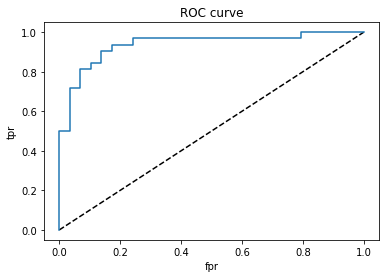

LogisticRegression 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9364224137931034
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



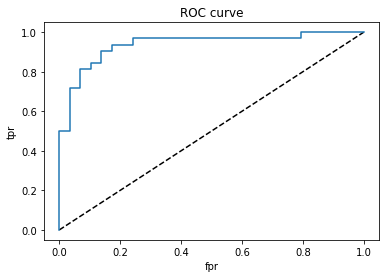

KNeighborsClassifier 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9364224137931034
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



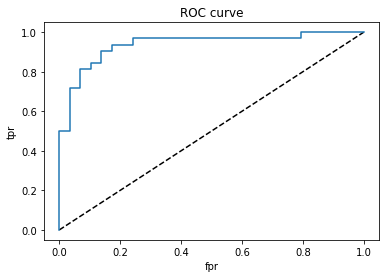

RandomForestClassifier 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9364224137931034
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



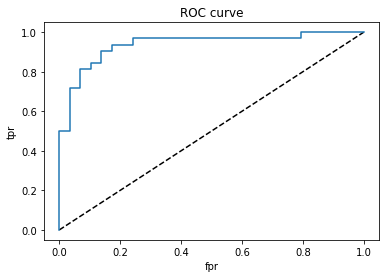

GradientBoostingClassifier 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9364224137931034
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



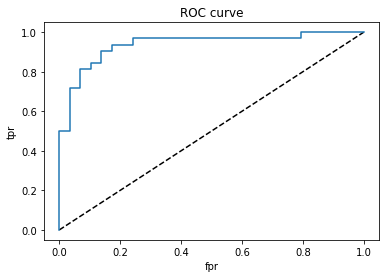

XGBClassifier 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9364224137931034
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



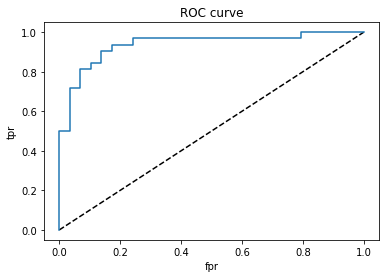

In [65]:
# Looping through models and evaluating their performance
for name, model in classifiers.items():
    model=algo
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    acc = accuracy_score(y_test, predict)
    conf = confusion_matrix(y_test, predict)
    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test,y_pred_proba)
        
    print("=============================================================================")
    print(name,acc)
    print(conf)    
    print(roc_auc)
    print(classification_report(y_test,predict))
    
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr, label='Knn')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.show()

# Hyperparameter Tuning RandomForest

In [ ]:
# instantiating the object
model = RandomForestClassifier()

# setting a grid - not so extensive
parameters = {'n_estimators': [50, 60],
    'max_depth': [2,3,10,15,20,25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# instantiating the GridSearchCV object
# For binary classification:
# 'accuracy': Calculates the accuracy of the classifier.
# 'precision': Measures the ability of the classifier not to label as positive a sample that is negative.
# 'recall': Measures the ability of the classifier to capture all the positive samples.
# 'f1': Combines precision and recall into a single metric.
# 'roc_auc': Computes the area under the Receiver Operating Characteristic (ROC) curve.

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5, scoring='accuracy')

# fitting the object
searcher.fit(X_train, y_train)

# the scores
print("The best params are :", searcher.best_params_)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

# Hyperparameter Tuning LOGREG

In [ ]:
# instantiating the object
model = LogisticRegression()

# Define a parameter grid
parameters = {
    'C': np.logspace(-3, 3,4, 5,7),  # Regularization parameter
    'penalty': ['None','l1', 'l2','elasticnet'],       # Regularization type
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],        # Solver algorithm
    'max_iter' :[50,100,200,300],
    'n_jobs' :[-1]
}

# instantiating the GridSearchCV object
# For binary classification:
# 'accuracy': Calculates the accuracy of the classifier.
# 'precision': Measures the ability of the classifier not to label as positive a sample that is negative.
# 'recall': Measures the ability of the classifier to capture all the positive samples.
# 'f1': Combines precision and recall into a single metric.
# 'roc_auc': Computes the area under the Receiver Operating Characteristic (ROC) curve.

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5, scoring='accuracy')

# fitting the object
searcher.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_params = searcher.best_params_

# the scores
print("The best params are :", best_params)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

# TURNING LOGREG MODEL INTO SQL IMPLEMENTATION

In [ ]:
print(best_params)
model=LogisticRegression(**best_params)
model.fit(X_train,y_train)
predict = model.predict(X_test)
acc = accuracy_score(y_test, predict)
conf = confusion_matrix(y_test, predict)

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test,y_pred_proba)

print(name,acc)
print(conf)    
print(roc_auc)
print(classification_report(y_test,predict))

In [ ]:
coefficients = model.coef_[0]
# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to display the coefficients along with the feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

intercept = model.intercept_[0]
print('Intercept =',intercept)

# Print the DataFrame
print(coefficients_df)
coefficients_list = coefficients_df.values.tolist()

# Get centering and scaling values for each feature
print("Centering",centering)
print("iqrs",iqrs)

In [ ]:
df1_Scored = df1
df1_Scored['prob_Manual'] =             1/(1+np.exp(-(intercept +  \
                                        coefficients_list[0][1] * (df1_Scored[coefficients_list[0][0]] - centering[0] ) / iqrs[0] + \
                                        coefficients_list[1][1] * (df1_Scored[coefficients_list[1][0]] - centering[1] ) / iqrs[1] + \
                                        coefficients_list[2][1] * (df1_Scored[coefficients_list[2][0]] - centering[2] ) / iqrs[2] + \
                                        coefficients_list[3][1] * (df1_Scored[coefficients_list[3][0]] - centering[3] ) / iqrs[3] + \
                                        coefficients_list[4][1] * (df1_Scored[coefficients_list[4][0]] - centering[4] ) / iqrs[4] + \
                                        coefficients_list[5][1] * (df1_Scored[coefficients_list[5][0]]) +  \
                                        coefficients_list[6][1] * (df1_Scored[coefficients_list[6][0]]) +  \
                                        coefficients_list[7][1] * (df1_Scored[coefficients_list[7][0]]) +  \
                                        coefficients_list[8][1] * (df1_Scored[coefficients_list[8][0]]) +  \
                                        coefficients_list[9][1] * (df1_Scored[coefficients_list[9][0]]) +  \
                                        coefficients_list[10][1] * (df1_Scored[coefficients_list[10][0]]) +  \
                                        coefficients_list[11][1] * (df1_Scored[coefficients_list[11][0]]) +  \
                                        coefficients_list[12][1] * (df1_Scored[coefficients_list[12][0]]) +  \
                                        coefficients_list[13][1] * (df1_Scored[coefficients_list[13][0]]) +  \
                                        coefficients_list[14][1] * (df1_Scored[coefficients_list[14][0]]) +  \
                                        coefficients_list[15][1] * (df1_Scored[coefficients_list[15][0]]) +  \
                                        coefficients_list[16][1] * (df1_Scored[coefficients_list[16][0]]) +  \
                                        coefficients_list[17][1] * (df1_Scored[coefficients_list[17][0]]) +  \
                                        coefficients_list[18][1] * (df1_Scored[coefficients_list[18][0]]) +  \
                                        coefficients_list[19][1] * (df1_Scored[coefficients_list[19][0]]) +  \
                                        coefficients_list[19][1] * (df1_Scored[coefficients_list[20][0]]) +  \
                                        coefficients_list[19][1] * (df1_Scored[coefficients_list[21][0]]) +  \
                                                      0 )))
                                                                                              
roc_auc = roc_auc_score(df1_Scored['output'],df1_Scored['prob_Manual'])
print(roc_auc)
df1_Scored[df1_Scored['output'] == 0].head(10)

In [ ]:
sql_table_name = ''
column_name = ''

In [ ]:
"""
SELECT
  1 / (1 + EXP(-(
    -- Intercept
    <intercept> +
    -- Coefficients for each feature
    <coef_1> * (feature_1 - <median_1>) / <iqr_1> +
    <coef_2> * (feature_2 - <median_2>) / <iqr_2> +
    -- ... Repeat for all features ...
    <coef_n> * (feature_n - <median_n>) / <iqr_n>
  ))) AS predicted_probability
FROM your_table_with_unscaled_features;
"""